### Import Package

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

### Load RVI Data

In [2]:
df = pd.read_csv('input/data_compile_agro_sentinel_1_rvi.csv')

In [3]:
df = df.iloc[:,1:]

In [4]:
df = df.loc[df.obs != 12]

### Plot

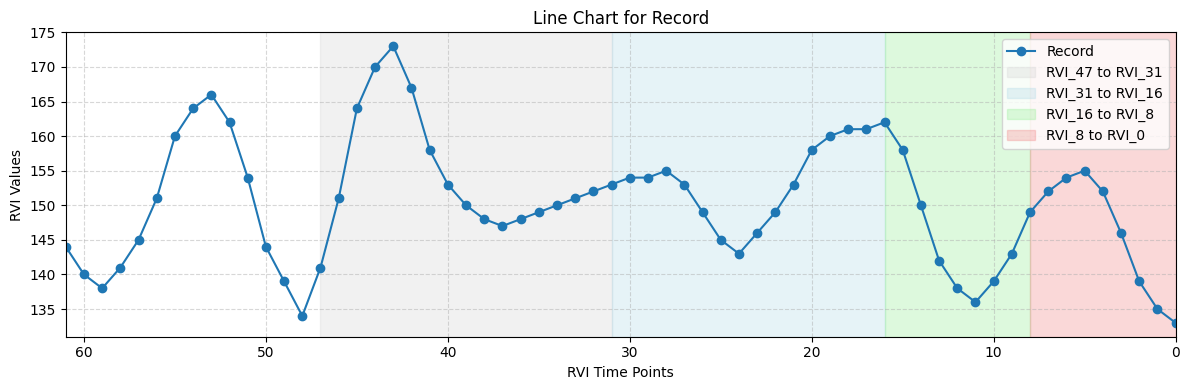

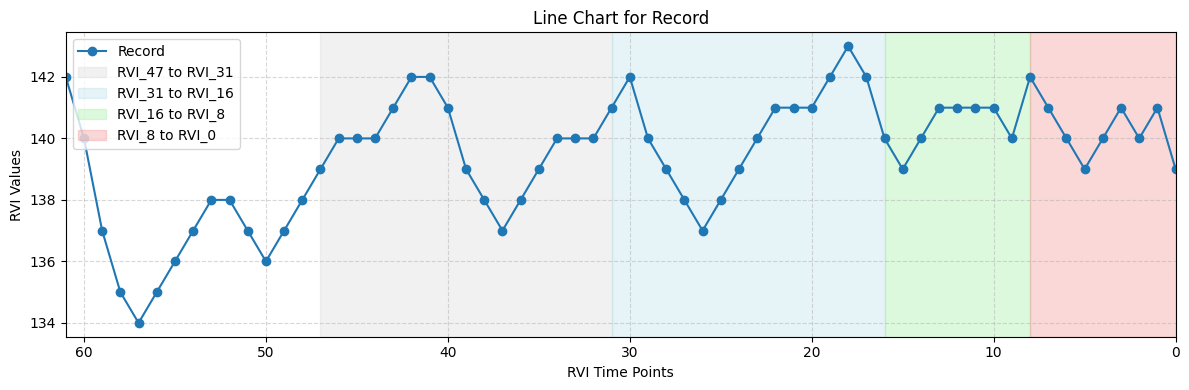

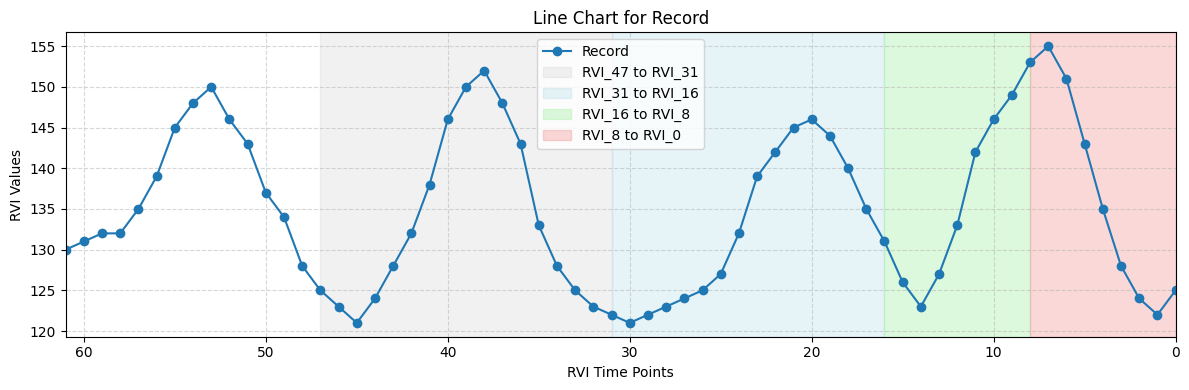

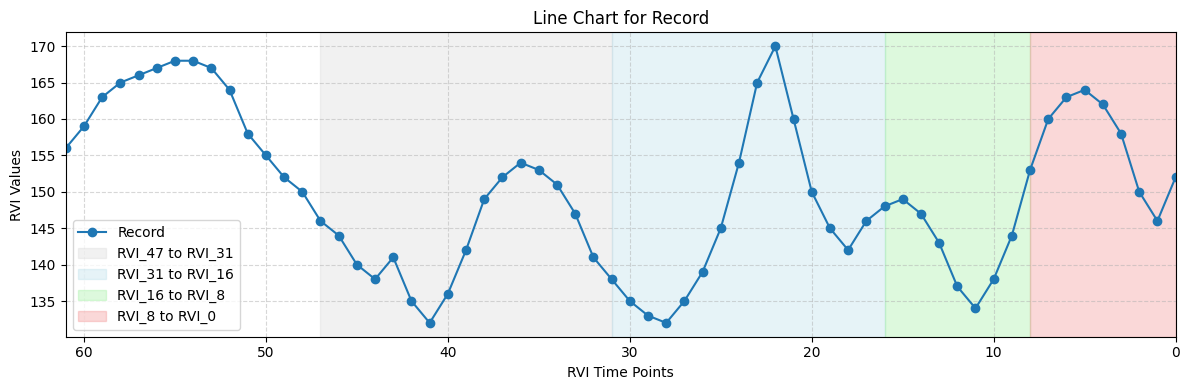

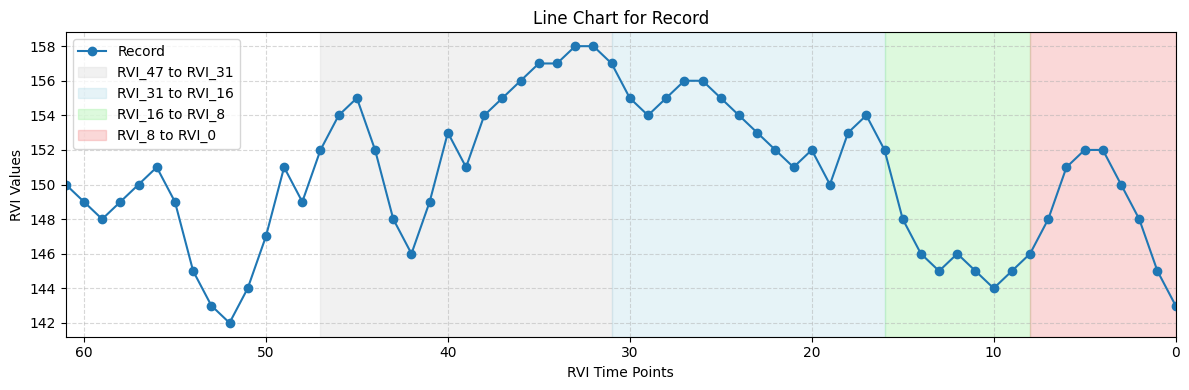

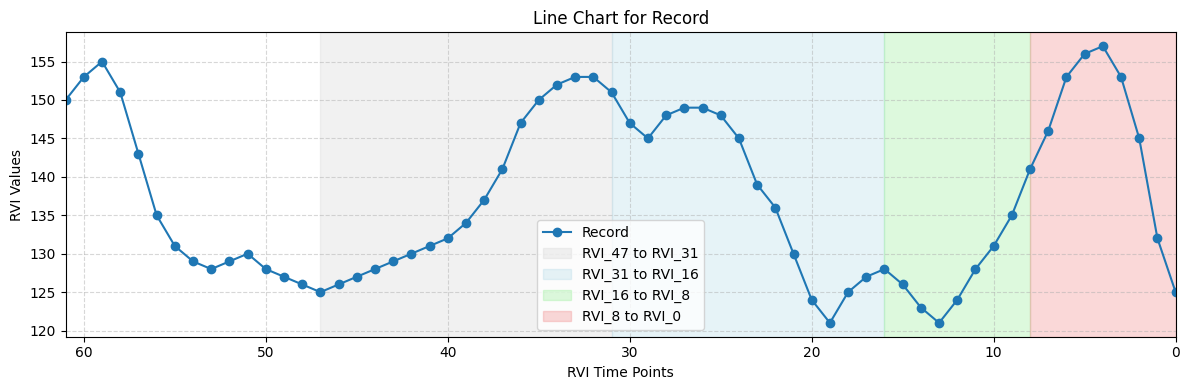

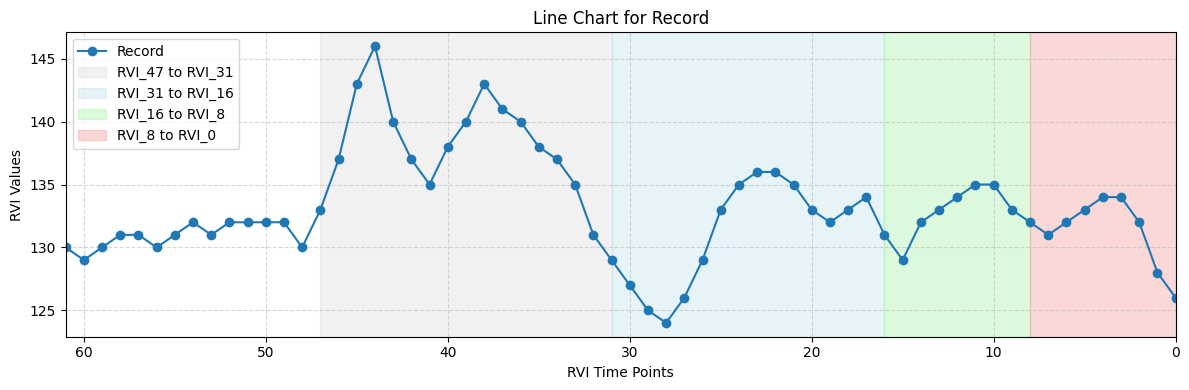

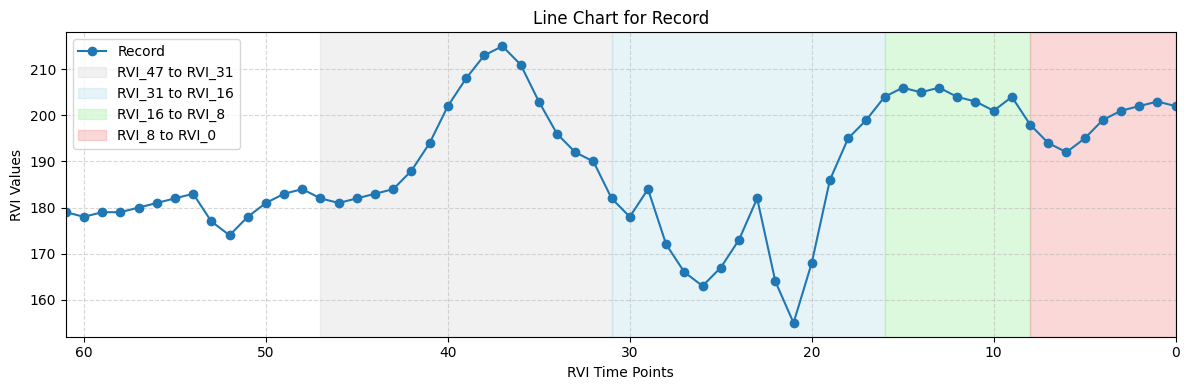

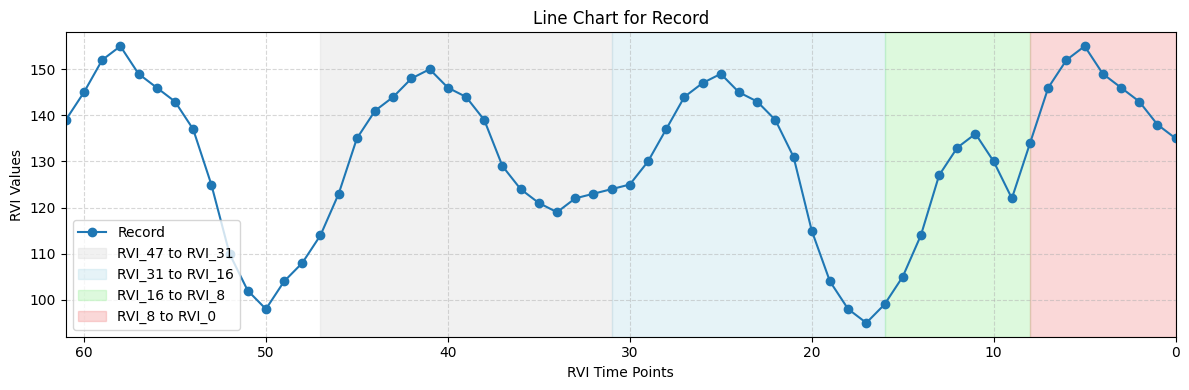

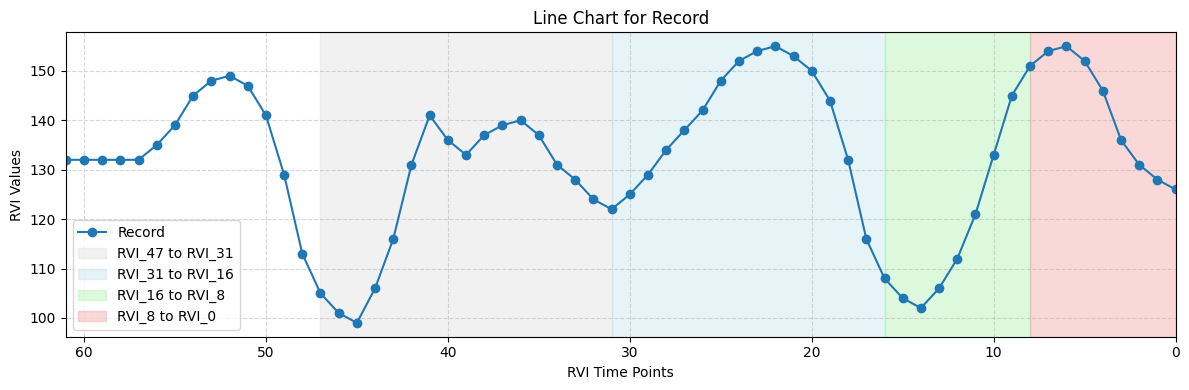

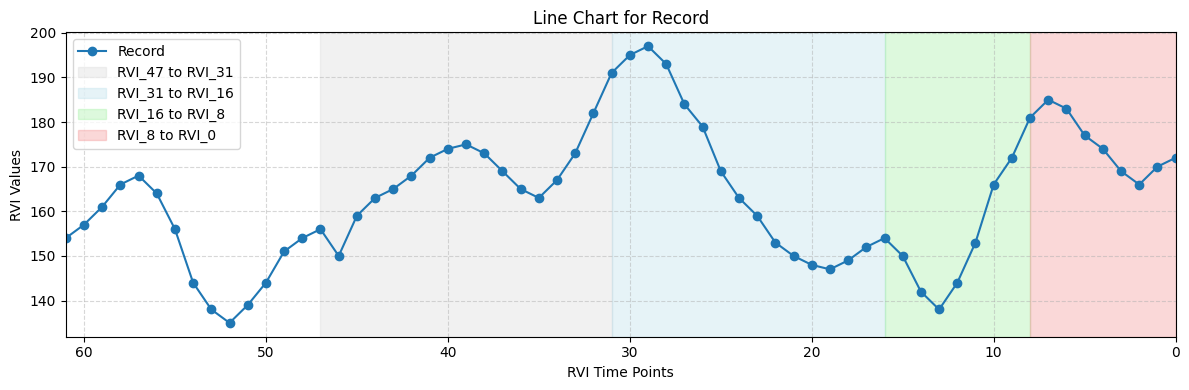

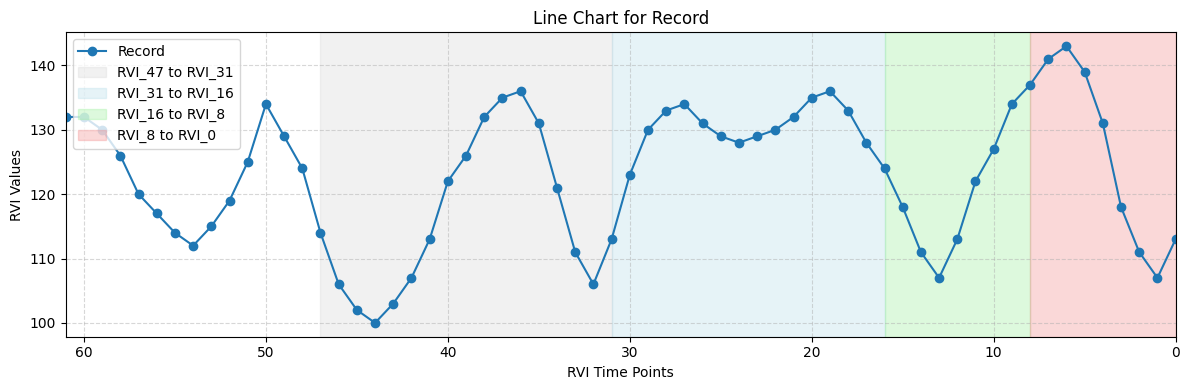

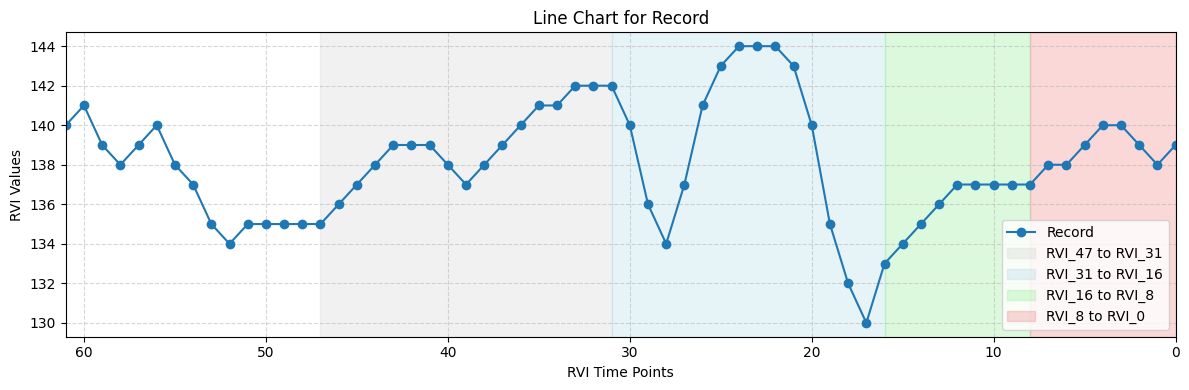

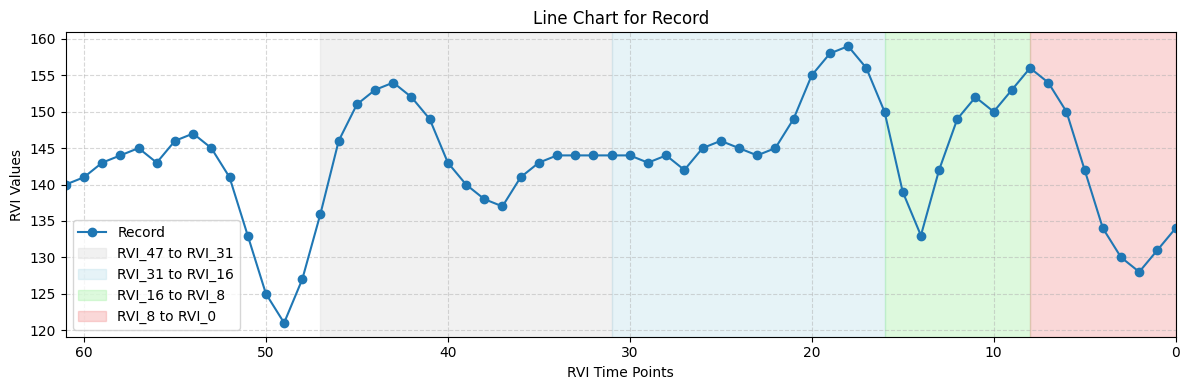

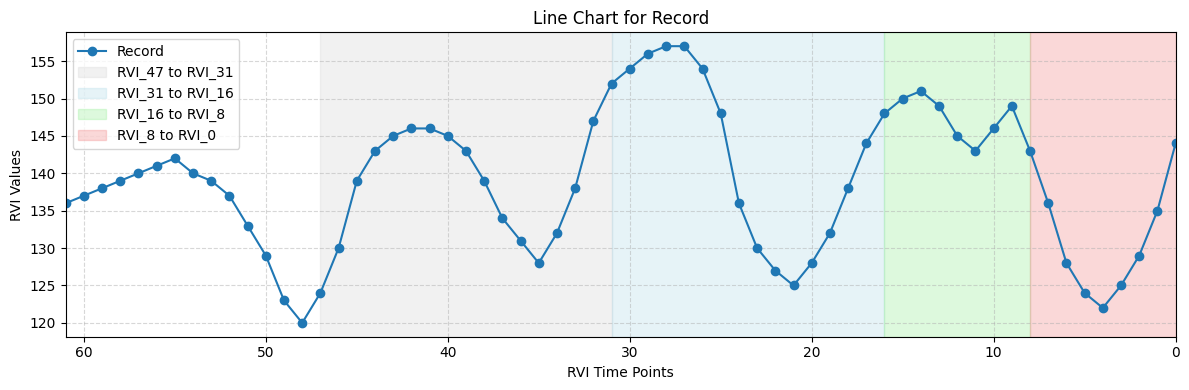

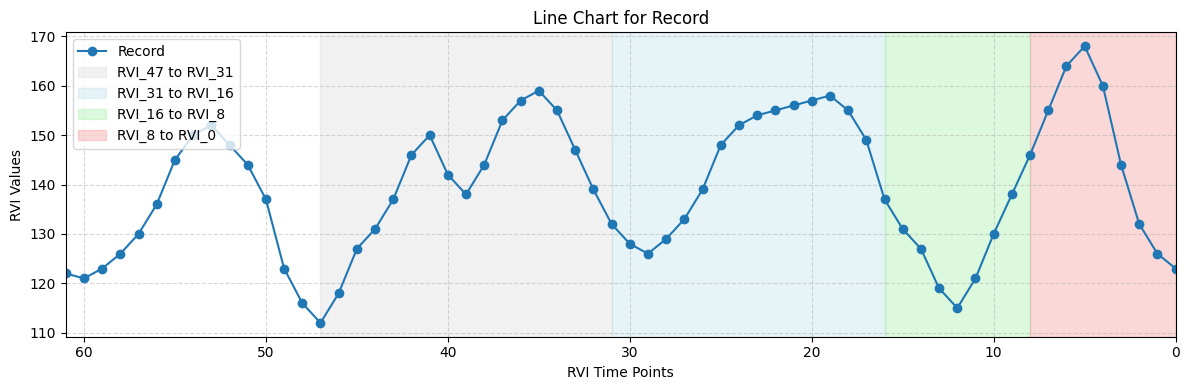

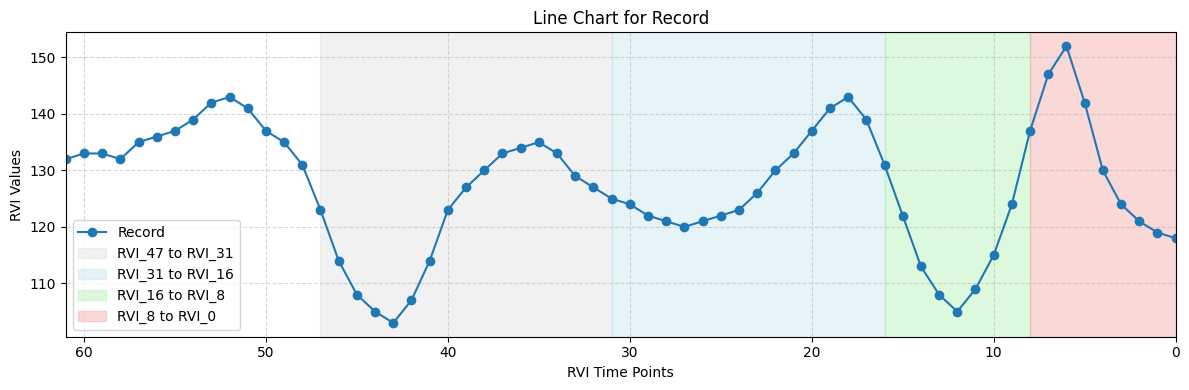

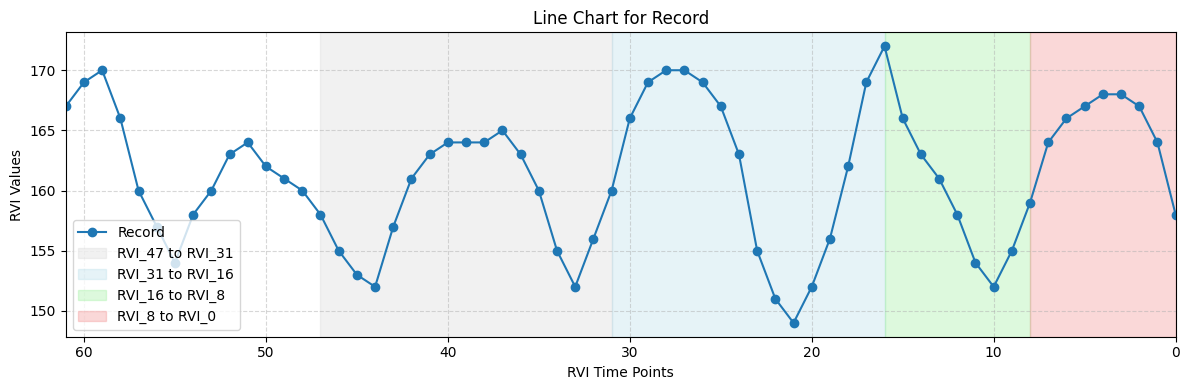

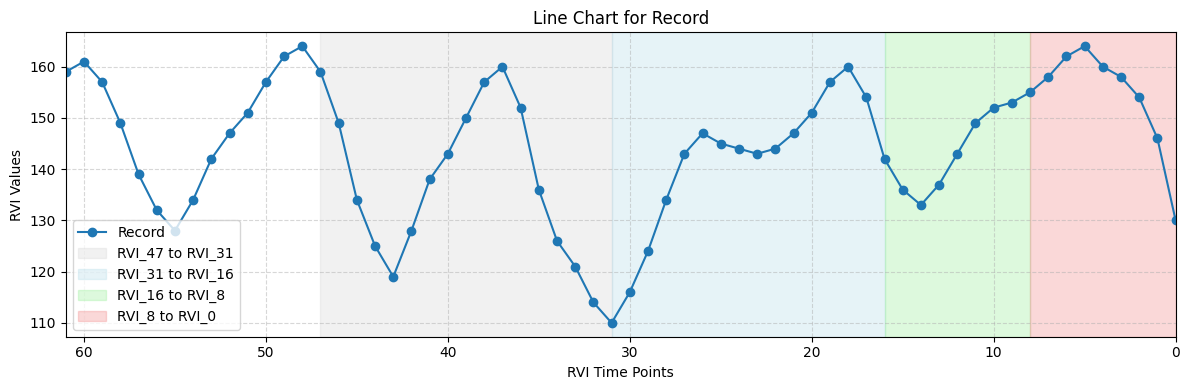

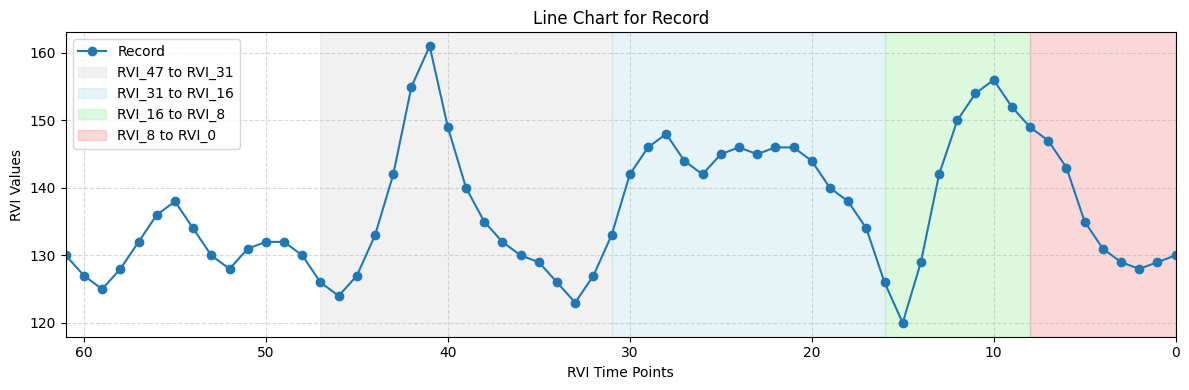

In [19]:
## Visualize PUSO

# Sample 20 records
sampled_df = df.query("is_puso == 1").sample(20, random_state=123)

# Plot line charts for each record
for _, row in sampled_df.iterrows():
    # Extract VH columns
    vh_values = row[[f'RVI_{i}' for i in range(61, -1, -1)]].astype(float).values
    time_points = list(range(61, -1, -1))  # Time points from VH_61 to VH_0
    
    # Plot the line chart
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time_points, vh_values, marker='o', label=f"Record")
    
    # Add background colors for specific regions
    ax.axvspan(31, 47, color='lightgrey', alpha=0.3, label='RVI_47 to RVI_31')
    ax.axvspan(16, 31, color='lightblue', alpha=0.3, label='RVI_31 to RVI_16')
    ax.axvspan(8, 16, color='lightgreen', alpha=0.3, label='RVI_16 to RVI_8')
    ax.axvspan(0, 8, color='lightcoral', alpha=0.3, label='RVI_8 to RVI_0')
    
    # Customize chart
    ax.set_title(f"Line Chart for Record")
    ax.set_xlabel("RVI Time Points")
    ax.set_ylabel("RVI Values")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(61, 0)  # Reverse X-axis to align VH_61 to VH_0 left-to-right
    
    # Save or show the plot
    plt.tight_layout()
    plt.show()

### Define Function Training

In [5]:
def training(X, y, scenario_name): 
    # Split data into train-test (70%-30%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=1234
    )
    
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)  # Majority/Minority class ratio
    
    # Stratified 3-Fold Cross Validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    metrics = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        # Train XGBoost model
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=1234,
                                  scale_pos_weight=scale_pos_weight)
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on validation data
        y_pred = model.predict(X_val_fold)
        y_prob = model.predict_proba(X_val_fold)[:, 1]  # Probabilities for positive class
    
        # Calculate metrics
        precision = precision_score(y_val_fold, y_pred, average=None, zero_division=0)
        recall = recall_score(y_val_fold, y_pred, average=None, zero_division=0)
        accuracy = accuracy_score(y_val_fold, y_pred)
        f1_macro = f1_score(y_val_fold, y_pred, average="macro")
        auc = roc_auc_score(y_val_fold, y_prob)
    
        metrics.append({
            "precision_per_class": precision,
            "recall_per_class": recall,
            "accuracy": accuracy,
            "f1_macro": f1_macro,
            "auc": auc
        })

    # Compute average metrics across folds
    avg_precision = np.mean([m["precision_per_class"] for m in metrics], axis=0)
    avg_recall = np.mean([m["recall_per_class"] for m in metrics], axis=0)
    avg_accuracy = np.mean([m["accuracy"] for m in metrics])
    avg_f1_macro = np.mean([m["f1_macro"] for m in metrics])
    avg_auc = np.mean([m["auc"] for m in metrics])
    
    print(f"Average Metrics across Folds ({scenario_name}):")
    print("Precision per class:", avg_precision)
    print("Recall per class:", avg_recall)
    print("Accuracy:", avg_accuracy)
    print("F1-Macro:", avg_f1_macro)
    print("AUC ROC:", avg_auc)
    
    # Train final model on the full training set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({scenario_name})")
    plt.show()

    # Feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False).head(8)
    print(f"\n Top 8 Features ({scenario_name}):\n", importance_df)

    # Final Metrics
    precision_test = precision_score(y_test, y_test_pred, average=None, zero_division=0)
    recall_test = recall_score(y_test, y_test_pred, average=None, zero_division=0)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_macro_test = f1_score(y_test, y_test_pred, average="macro")
    auc_test = roc_auc_score(y_test, y_test_prob)
    
    print(f"\nPrecision per class (Test) ({scenario_name}):", precision_test)
    print(f"Recall per class (Test) ({scenario_name}):", recall_test)
    print(f"Accuracy (Test) ({scenario_name}):", accuracy_test)
    print(f"F1-Macro (Test) ({scenario_name}):", f1_macro_test)
    print(f"AUC ROC (Test) ({scenario_name}):", auc_test)
    
    # Classification Report
    print(f"\nClassification Report (Test) ({scenario_name}):")
    print(classification_report(y_test, y_test_pred, target_names=["Class 0", "Class 1"]))
    
    # Return metrics for the current scenario
    return {
        "scenario": scenario_name,
        "precision_class_0": avg_precision[0],
        "precision_class_1": avg_precision[1],
        "recall_class_0": avg_recall[0],
        "recall_class_1": avg_recall[1],
        "accuracy": avg_accuracy,
        "f1_macro": avg_f1_macro,
        "auc": avg_auc,
        "precision_test_class_0": precision_test[0],
        "precision_test_class_1": precision_test[1],
        "recall_test_class_0": recall_test[0],
        "recall_test_class_1": recall_test[1],
        "accuracy_test": accuracy_test,
        "f1_macro_test": f1_macro_test,
        "auc_test": auc_test,
        "top_5_features": importance_df
    }

### Modelling RVI for 3 Months

In [7]:
X = df.iloc[:,-8:]
y = df["is_puso"]

Average Metrics across Folds (3 Bulan):
Precision per class: [0.88893519 0.25038767]
Recall per class: [0.89868624 0.22974319]
Accuracy: 0.8135929741754849
F1-Macro: 0.5664653685207325
AUC ROC: 0.6441127688200782


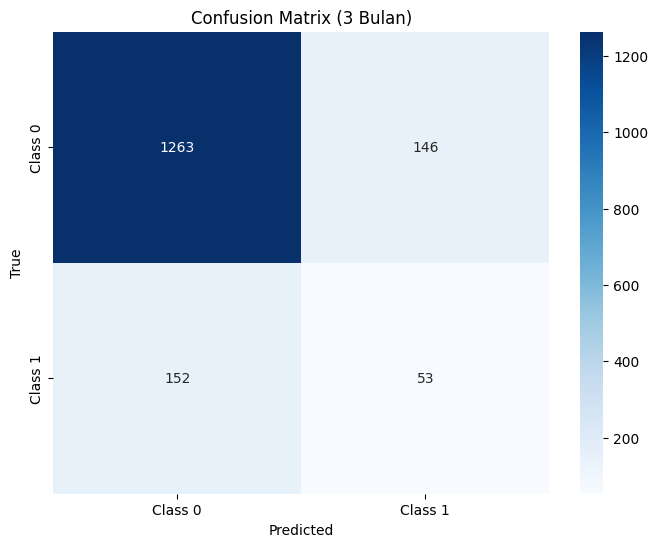


 Top 8 Features (3 Bulan):
   Feature  Importance
6   RVI_1    0.171295
3   RVI_4    0.130993
2   RVI_5    0.126689
4   RVI_3    0.125555
7   RVI_0    0.120605
0   RVI_7    0.110628
5   RVI_2    0.109208
1   RVI_6    0.105026

Precision per class (Test) (3 Bulan): [0.89257951 0.26633166]
Recall per class (Test) (3 Bulan): [0.89638041 0.25853659]
Accuracy (Test) (3 Bulan): 0.815365551425031
F1-Macro (Test) (3 Bulan): 0.5784260791518245
AUC ROC (Test) (3 Bulan): 0.6138551818449343

Classification Report (Test) (3 Bulan):
              precision    recall  f1-score   support

     Class 0       0.89      0.90      0.89      1409
     Class 1       0.27      0.26      0.26       205

    accuracy                           0.82      1614
   macro avg       0.58      0.58      0.58      1614
weighted avg       0.81      0.82      0.81      1614



In [8]:
metrics_3bulan = training(X, y, "3 Bulan")
all_metrics.append(metrics_3bulan)

### Modelling RVI for 12 Months

In [10]:
X = df.iloc[:,-31:]
y = df["is_puso"]

Average Metrics across Folds (12 Bulan):
Precision per class: [0.89136056 0.41022199]
Recall per class: [0.95832056 0.19840147]
Accuracy: 0.8616557126060513
F1-Macro: 0.5950834934204335
AUC ROC: 0.6882780665198679


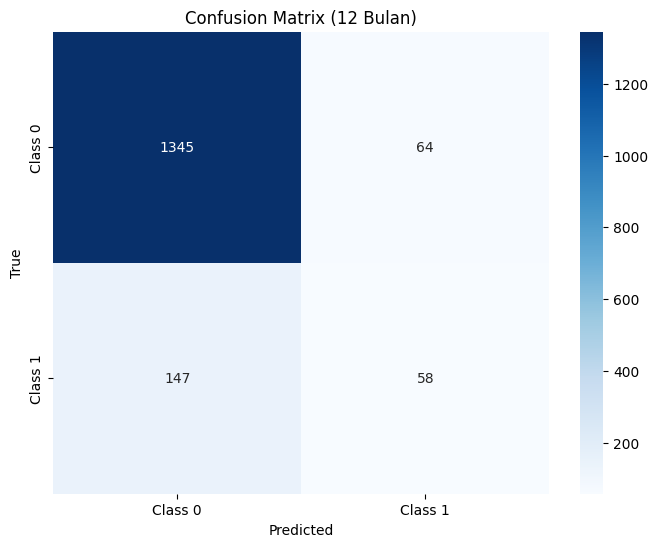


 Top 8 Features (12 Bulan):
    Feature  Importance
29   RVI_1    0.064565
30   RVI_0    0.039989
17  RVI_13    0.039590
23   RVI_7    0.039040
13  RVI_17    0.038555
21   RVI_9    0.036359
19  RVI_11    0.034943
20  RVI_10    0.034586

Precision per class (Test) (12 Bulan): [0.90147453 0.47540984]
Recall per class (Test) (12 Bulan): [0.95457771 0.28292683]
Accuracy (Test) (12 Bulan): 0.869268897149938
F1-Macro (Test) (12 Bulan): 0.6410032605017567
AUC ROC (Test) (12 Bulan): 0.7093700773771399

Classification Report (Test) (12 Bulan):
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.93      1409
     Class 1       0.48      0.28      0.35       205

    accuracy                           0.87      1614
   macro avg       0.69      0.62      0.64      1614
weighted avg       0.85      0.87      0.85      1614



In [11]:
metrics_12bulan = training(X, y, "12 Bulan")
all_metrics.append(metrics_12bulan)

### Modelling RVI for 24 Months

In [13]:
X = df.iloc[:,-62:]
y = df["is_puso"]

Average Metrics across Folds (24 Bulan):
Precision per class: [0.89053628 0.45912159]
Recall per class: [0.96775211 0.18371331]
Accuracy: 0.8680314834081931
F1-Macro: 0.5945532687973111
AUC ROC: 0.7027015866940559


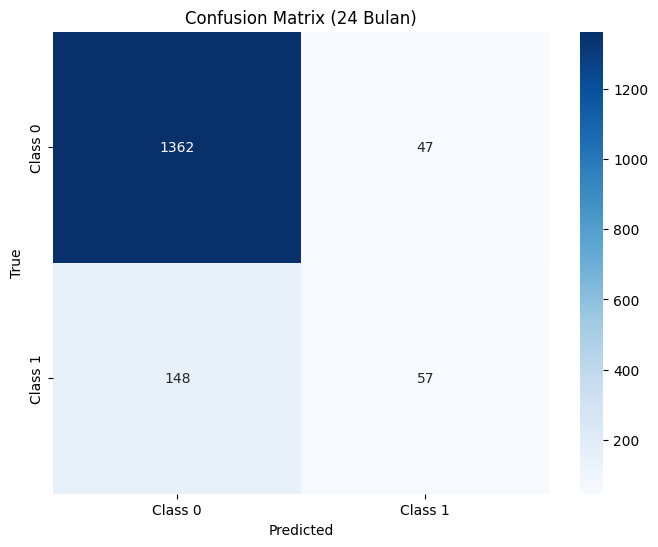


 Top 8 Features (24 Bulan):
    Feature  Importance
60   RVI_1    0.054489
54   RVI_7    0.027717
23  RVI_38    0.027320
50  RVI_11    0.026310
56   RVI_5    0.025008
48  RVI_13    0.023748
7   RVI_54    0.019981
61   RVI_0    0.019605

Precision per class (Test) (24 Bulan): [0.90198675 0.54807692]
Recall per class (Test) (24 Bulan): [0.96664301 0.27804878]
Accuracy (Test) (24 Bulan): 0.879182156133829
F1-Macro (Test) (24 Bulan): 0.6510641694688631
AUC ROC (Test) (24 Bulan): 0.7224359085322578

Classification Report (Test) (24 Bulan):
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93      1409
     Class 1       0.55      0.28      0.37       205

    accuracy                           0.88      1614
   macro avg       0.73      0.62      0.65      1614
weighted avg       0.86      0.88      0.86      1614



In [14]:
metrics_24bulan = training(X, y, "24 Bulan")
all_metrics.append(metrics_24bulan)